In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Contents**
* Importing varoius libraries/packages and loading the Dataset
* Text Cleaning
* Formation of various collections
* Splitting up data into text-train
* Encoder - Decoder Architecture

## Importing varoius libraries/packages and loading the Dataset

In [2]:
# Importing some important libraries
import string
import re
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**About the Dataset:** 
There are 2 columns one column has english words/sentences and the other one has french words/sentences.
For datasets of other languages : http://www.manythings.org/anki/

In [3]:
# Loading the Dataset
df= pd.read_csv("eng_-french.csv")
df

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !
...,...,...
175616,"Top-down economics never works, said Obama. ""T...","« L'économie en partant du haut vers le bas, ç..."
175617,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
175618,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
175619,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...


## Text Cleaning

All the text cleaning functions are applied for both the languages which mainly includes lowercasing, removing quotes, removing special characters, removing all numbers from text and removing extra spaces.

In [4]:
# Lowercase all characters
df['English words/sentences']=df['English words/sentences'].apply(lambda x: x.lower())
df['French words/sentences']=df['French words/sentences'].apply(lambda x: x.lower())

# Remove quotes
df['English words/sentences']=df['English words/sentences'].apply(lambda x: re.sub("'", '', x))
df['French words/sentences']=df['French words/sentences'].apply(lambda x: re.sub("'", '', x))

exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
df['English words/sentences']=df['English words/sentences'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
df['French words/sentences']=df['French words/sentences'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
df['English words/sentences']=df['English words/sentences'].apply(lambda x: x.translate(remove_digits))
df['French words/sentences']=df['French words/sentences'].apply(lambda x: x.translate(remove_digits))

# Remove extra spaces
df['English words/sentences']=df['English words/sentences'].apply(lambda x: x.strip())
df['French words/sentences']=df['French words/sentences'].apply(lambda x: x.strip())
df['English words/sentences']=df['English words/sentences'].apply(lambda x: re.sub(" +", " ", x))
df['French words/sentences']=df['French words/sentences'].apply(lambda x: re.sub(" +", " ", x))


We'll now **add _START and _END** to the start and end of the target sentences respectively. I'll explain later on why we did this.

In [5]:
df['French words/sentences'] = df['French words/sentences'].apply(lambda x : 'START_ '+ x + ' _END')
df

,English words/sentences,French words/sentences
0,hi,START_ salut _END
1,run,START_ cours _END
2,run,START_ courez _END
3,who,START_ qui _END
4,wow,START_ ça alors _END
...,...,...
175616,topdown economics never works said obama the c...,START_ « léconomie en partant du haut vers le ...
175617,a carbon footprint is the amount of carbon dio...,START_ une empreinte carbone est la somme de p...
175618,death is something that were often discouraged...,START_ la mort est une chose quon nous découra...
175619,since there are usually multiple websites on a...,START_ puisquil y a de multiples sites web sur...


## Formation of various collections

Along our journey of NMT, we will need various list, dictionaries and collections mainly comprising of total vocabulary(both languages), dictionary of words indexed by words and also dictionary of numbers indexed by the numbers(or tokens).

In [6]:
# Vocabulary of English
all_eng_words=set()
for eng in df['English words/sentences']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

# Vocabulary of French 
all_french_words=set()
for fr in df['French words/sentences']:
    for word in fr.split():
        if word not in all_french_words:
            all_french_words.add(word)

In [7]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_french_words))

In [8]:
words_idx_eng_num = dict([(word, i+1) for  i,word in enumerate(input_words)])
words_idx_fr_num = dict([(word, i+1) for  i,word in enumerate(target_words)])

In [9]:
words_idx_eng_num['would']

14279

words_idx_eng_num : Dictionary of all English words indexed by words \
words_idx_fr_num : Dictionary of all French words indexed by words

In [10]:
num_idx_eng_words = dict((i, word) for word, i in words_idx_eng_num.items())
num_idx_fr_words = dict((i, word) for word, i in words_idx_fr_num.items())

In [11]:
num_idx_eng_words[14279]

'would'

num_idx_eng_words : Dictionary of all English words indexed by numbers \
num_idx_fr_words : Dictionary of all French words indexed by numbers

In [12]:
max_eng=0
for i in range(0, df.shape[0]):
    if(max_eng<len([word for word in df['English words/sentences'][i].split()])):
        j=i
        max_eng = len([word for word in df['English words/sentences'][i].split()])

print(j)
print(max_eng)
print(len([word for word in df['French words/sentences'][j].split()]))

175620
44
57


Therefore the the biggest sentence(in English) is at the end of the data.


In [13]:
max_fr=0
for i in range(0, df.shape[0]):
    if(max_fr<len([word for word in df['French words/sentences'][i].split()])):
        j=i
        max_fr = len([word for word in df['French words/sentences'][i].split()])

print(j)
print(max_fr)
print(len([word for word in df['English words/sentences'][j].split()]))

175620
57
44


Therefore the the biggest sentence(in French) is also at the end of the data.

We save the maximum lenght of english sentence and french sentence as a `max_eng` and `max_fr` respectively. These will be used ahead in encoder-decoder architecture while generating a batch of input data.

In [14]:
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_french_words)
print(num_encoder_tokens)
print(num_decoder_tokens)
num_encoder_tokens = num_encoder_tokens + 1
print(num_encoder_tokens)
num_decoder_tokens = num_decoder_tokens + 1
print(num_decoder_tokens)

14409
29397
14410
29398


## Splitting up the dataset

In [15]:
# Splitting of our dataset into Test-Train
from sklearn.model_selection import train_test_split
X, y = df['English words/sentences'], df['French words/sentences']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

((158058,), (17563,))

In [16]:
X_train

61381                               i just dont believe you
154253           i wasnt ready for what was about to happen
115306                      i understand but i cannot agree
84670                           my father has gone to china
26785                                     were just nervous
                                ...                        
11474                                        im not nervous
131461                  tom is probably not happy right now
167757    education is one of the most essential aspects...
138598                the mere sight of a dog frightens him
147521               ill lend you some books of my brothers
Name: English words/sentences, Length: 158058, dtype: object

In [17]:
y_train

61381        START_ je ne te crois tout simplement pas _END
154253    START_ je ne mattendais pas à ce qui allait ar...
115306    START_ je comprends mais je ne peux pas être d...
84670                START_ mon père est allé en chine _END
26785            START_ nous sommes simplement nerveux _END
                                ...                        
11474                   START_ je ne suis pas nerveuse _END
131461    START_ tom nest probablement pas heureux en ce...
167757    START_ il ny a rien de plus important dans la ...
138598    START_ le simple fait de voir un chien lui fai...
147521    START_ je vous prêterai quelques livres de mon...
Name: French words/sentences, Length: 158058, dtype: object

## Encoder-Decoder Architecture

In [18]:
# Importing requirements for ENC-DEC Architecture
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from sklearn.utils import shuffle

In [19]:
# Setting the parameters
latent_dim = 50
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 10

In [20]:
def generate_batch(X, y, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_eng),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_fr),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_fr, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = words_idx_eng_num[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = words_idx_fr_num[word] # decoder input seq
                    if t>0:
                        decoder_target_data[i, t - 1, words_idx_fr_num[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

i refers to batch number \
t refers to the position of that word in that sentence
sequence of words for each batch is saved as the number for that word(for eg 2399 for 'would')

We dont consider the '_END' while giving an input to decoder therefore the first if function
Decoder target sequence does not include the 'START_' token and thus we have used t-1 and given it the value 1 and others all are zero indicating that particular word exists(3rd dimension is number of french words) and the others are not


In [21]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# **LSTM:**

![Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.png](attachment:Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.png)

Here we instantiate a tensor 'encoder_inputs' and by passing the shape=(None,) we can have have dimension as any scalar number. It will be mainly filled by . \
We further use the embeddings layer to calculate the embeddings of all the input words(i.e all words in a sentence). All the embeddings will be of the dimension 'latent_dim'

We then mainly consider the encoder states(state h and state c)



In [22]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Here we instantiate a tensor 'decoder_inputs' and by passing the shape=(None,) we can have have dimension as any scalar number. It will be mainly filled by the output states of the encoder \
We further use the embeddings layer to calculate the embeddings of all the input words(i.e all words in a sentence). All the embeddings will be of the dimension 'latent_dim' \
We will use the initial states of decoder as the final states of encoder 

We then apply a dense layer with softmax activation to choose the output word at each time over all the target(french) words \

We then define the model

In [23]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

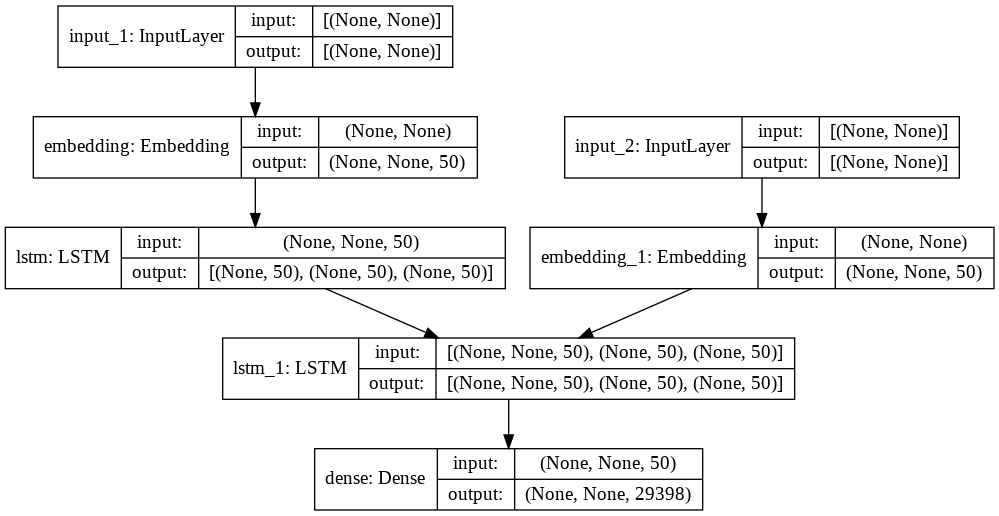

In [24]:
from keras.utils import plot_model
plot_model(model, to_file='train_model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='train_model.png')

In [25]:
TF_FORCE_GPU_ALLOW_GROWTH= True

In [26]:
model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),steps_per_epoch = train_samples//batch_size,epochs=10,validation_data = generate_batch(X_test, y_test, batch_size = batch_size),validation_steps = val_samples//batch_size)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1234/1234 [==============================] - 801s 639ms/step - loss: 0.8400 - acc: 0.1576 - val_loss: 0.6377 - val_acc: 0.2687
Epoch 2/10
1234/1234 [==============================] - 795s 644ms/step - loss: 0.6149 - acc: 0.2893 - val_loss: 0.5630 - val_acc: 0.3346
Epoch 3/10
1234/1234 [==============================] - 793s 643ms/step - loss: 0.5498 - acc: 0.3439 - val_loss: 0.5211 - val_acc: 0.3716
Epoch 4/10
1234/1234 [==============================] - 793s 643ms/step - loss: 0.5091 - acc: 0.3813 - val_loss: 0.4925 - val_acc: 0.4006
Epoch 5/10
1234/1234 [==============================] - 797s 646ms/step - loss: 0.4817 - acc: 0.4089 - val_loss: 0.4742 - val_acc: 0.4217
Epoch 6/10
1234/1234 [==============================] - 795s 644ms/step - loss: 0.4621 - acc: 0.4309 - val_loss: 0.4588 - val_acc: 0.4405
Epoch 7/10
1234/1234 [==============================] - 795s 644ms/step - loss: 0.4463 - acc: 0.4493 - val_loss: 0.4470 - val_acc: 0.4548
Epoch 8/10
1234/1234 [============

In [27]:
model.save_weights('mt_weights2.h5')

In [28]:
#model.load_weights('mt_weights (1).h5')

In [29]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [30]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = words_idx_fr_num['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = num_idx_fr_words[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [31]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [35]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual French Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted French Translation:', decoded_sentence[:-4])

Input English sentence: my father has gone to china
Actual French Translation:  mon père est allé en chine 
Predicted French Translation:  mon père est allé au lit 


I hope you guys have got an intuitive understanding of the emcoder-decoder architecture and how we can use it in Seq-2-Seq tasks like we used in Neural Machine Translation.

I have used GPU to train the model on Google Collab and have ran only for 10 epochs and thus a poor accuracy. The aim of this notebook was to mainly help you guys to understand the code.

# Do upvote if you like my work! 
# :)